In [6]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [5]:
!kaggle datasets download -d rasel180118/crops-disease-dataset

 98% 1.32G/1.35G [00:13<00:00, 103MB/s] 
100% 1.35G/1.35G [00:13<00:00, 106MB/s]


In [7]:
import zipfile
zip_ref = zipfile.ZipFile('/content/crops-disease-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import ResNet50, MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_hub as hub

In [9]:
# Set paths for your dataset
train_path = '/content/Crops_disease_dataset/Train'
valid_path = '/content/Crops_disease_dataset/Val'
test_path = '/content/Crops_disease_dataset/Test'

In [10]:
# Define image dimensions and batch size
img_size = (224, 224)
batch_size = 32

In [11]:

# Create data generators with augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 11951 images belonging to 22 classes.


In [12]:

# Create data generators with augmentation for training data
valid_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

valid_generator = valid_datagen.flow_from_directory(
    valid_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 1495 images belonging to 22 classes.


In [13]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 1497 images belonging to 22 classes.


In [14]:
import tensorflow_hub as hub

resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"
mobilenet_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

resnet_model = hub.KerasLayer(resnet_url, input_shape=(224, 224, 3))
mobilenet_model = hub.KerasLayer(mobilenet_url, input_shape=(224, 224, 3))


In [15]:
# Define input layer
from tensorflow.keras.layers import Input, Concatenate, Dense
input_layer = Input(shape=(224, 224, 3))

# Connect input to both models
resnet_features = resnet_model(input_layer)
mobilenet_features = mobilenet_model(input_layer)

In [16]:
# Concatenate the features from both models
concatenated_features = Concatenate()([resnet_features, mobilenet_features])

# Add additional layers as needed
dense_layer = Dense(512, activation='relu')(concatenated_features)
output_layer = Dense(train_generator.num_classes, activation='softmax')(dense_layer)

In [17]:
from tensorflow.keras.models import Model
# Create the combined model
hybrid_model = Model(inputs=input_layer, outputs=output_layer)

In [18]:
# Freeze the pre-trained layers
resnet_model.trainable = False
mobilenet_model.trainable = False


In [19]:
hybrid_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [20]:
history = hybrid_model.fit(
    train_generator,
    epochs=30,
    validation_data=valid_generator
)

Epoch 1/30
374/374 [==============================] - 235s 594ms/step - loss: 0.5454 - accuracy: 0.8243 - val_loss: 0.2492 - val_accuracy: 0.9164
Epoch 2/30
374/374 [==============================] - 202s 540ms/step - loss: 0.2402 - accuracy: 0.9153 - val_loss: 0.1909 - val_accuracy: 0.9304
Epoch 3/30
374/374 [==============================] - 203s 542ms/step - loss: 0.1882 - accuracy: 0.9345 - val_loss: 0.1298 - val_accuracy: 0.9485
Epoch 4/30
374/374 [==============================] - 199s 533ms/step - loss: 0.1615 - accuracy: 0.9448 - val_loss: 0.1395 - val_accuracy: 0.9525
Epoch 5/30
374/374 [==============================] - 202s 540ms/step - loss: 0.1385 - accuracy: 0.9530 - val_loss: 0.1321 - val_accuracy: 0.9485
Epoch 6/30
374/374 [==============================] - 200s 534ms/step - loss: 0.1156 - accuracy: 0.9593 - val_loss: 0.0851 - val_accuracy: 0.9686
Epoch 7/30
374/374 [==============================] - 219s 585ms/step - loss: 0.1122 - accuracy: 0.9618 - val_loss: 0.0826 -

In [21]:
test_loss, test_accuracy = hybrid_model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

47/47 [==============================] - 11s 243ms/step - loss: 0.0346 - accuracy: 0.9906
Test Accuracy: 99.06%


In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['accuracy']
val_loss = history.history['val_loss']

In [23]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Training and validation loss')

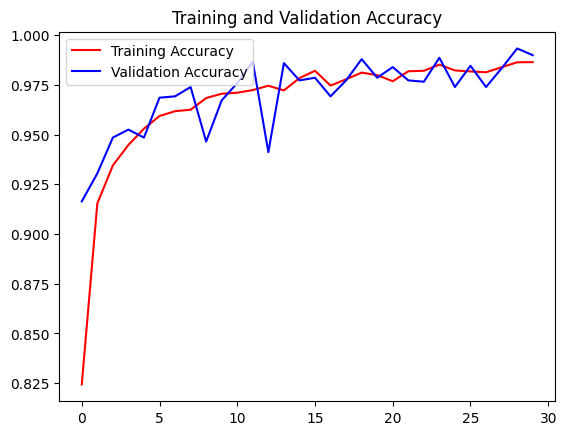

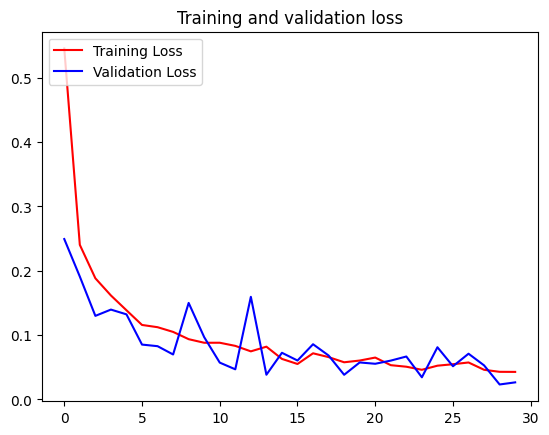

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label = 'Traning Accuracy')
plt.plot(epochs, val_acc, 'b', label = 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc = 'upper left')
plt.figure()


plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation  Loss")
plt.legend(['Training Loss', 'Validation Loss'], loc='upper left')

plt.title('Training and validation loss')

In [25]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

In [26]:
# Evaluate the model on a test dataset if available
test_generator = test_datagen.flow_from_directory(
    '/content/Crops_disease_dataset/Test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Set shuffle to False to get correct labels for confusion matrix
)

Found 1497 images belonging to 22 classes.


In [27]:
# Predict on test data
predictions = hybrid_model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

47/47 [==============================] - 9s 179ms/step


In [28]:
# Confusion Matrix
conf_mat = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_mat)

Confusion Matrix:
[[ 42   2   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0]
 [  1  45   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0]
 [  0   0  10   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0]
 [  0   0   0  10   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0]
 [  0   0   0   0  10   0   0   0   0   0   0   0   0   0   1   0   0   0
    0   0   0   0]
 [  0   0   0   0   0  17   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0]
 [  0   0   0   0   0   0  12   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0]
 [  0   0   0   0   0   0   0  42   0   0   0   0   0   0   0   0   0   0
    0   0   0   0]
 [  0   0   0   0   0   0   0   0  44   0   0   0   0   0   0   0   0   0
    0   0   0   0]
 [  0   0   0   0   0   0   0   0   0  45   0   0   0   0   0   0   0   0
    0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0 100   0   

In [29]:
# Classification Report
print("\nClassification Report:")
target_names = list(test_generator.class_indices.keys())
print(classification_report(y_true, y_pred, target_names=target_names))


Classification Report:
                                               precision    recall  f1-score   support

                       Bean_angular_leaf_spot       0.98      0.95      0.97        44
                               Bean_bean_rust       0.96      0.98      0.97        46
             Cauliflower_Alternaria_Leaf_Spot       1.00      1.00      1.00        10
                        Cauliflower_Black_Rot       1.00      1.00      1.00        10
             Cauliflower_Cabbage aphid colony       1.00      0.91      0.95        11
                     Cauliflower_Downy_Mildew       1.00      1.00      1.00        17
                        Cauliflower_ring spot       1.00      1.00      1.00        12
                  Paddy_Bacterial leaf blight       1.00      1.00      1.00        42
                             Paddy_Brown spot       1.00      1.00      1.00        44
                              Paddy_Leaf smut       1.00      1.00      1.00        45
                  

In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Make predictions on the test data
predictions = hybrid_model.predict(test_generator)
predicted_labels = tf.argmax(predictions, axis=1)
true_labels = test_generator.classes

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

47/47 [==============================] - 8s 173ms/step


In [31]:
trainData = tf.keras.preprocessing.image_dataset_from_directory(train_path)
class_names = trainData.class_names
class_names

Found 11951 files belonging to 22 classes.


['Bean_angular_leaf_spot',
 'Bean_bean_rust',
 'Cauliflower_Alternaria_Leaf_Spot',
 'Cauliflower_Black_Rot',
 'Cauliflower_Cabbage aphid colony',
 'Cauliflower_Downy_Mildew',
 'Cauliflower_ring spot',
 'Paddy_Bacterial leaf blight',
 'Paddy_Brown spot',
 'Paddy_Leaf smut',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

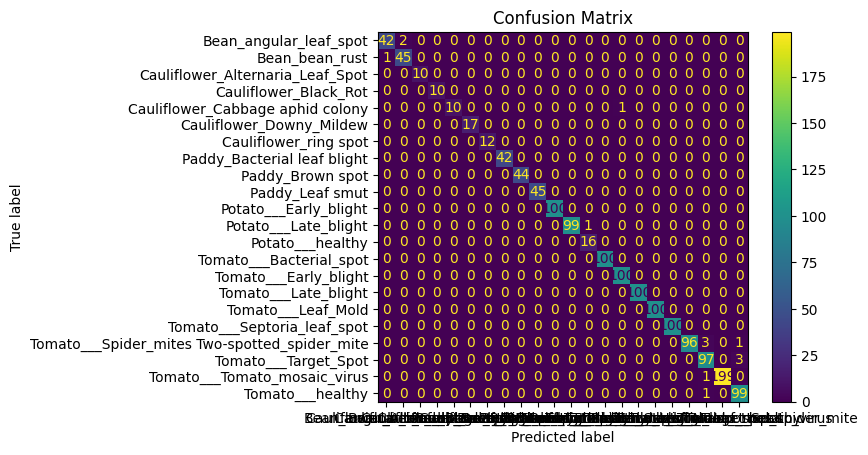

In [32]:
# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap='viridis', values_format='d')
plt.title('Confusion Matrix')
plt.show()

In [34]:
# Predict on test data
predictions = hybrid_model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

47/47 [==============================] - 9s 196ms/step


In [35]:
# Calculate accuracy, precision, recall, and F1 score
accuracy = np.trace(conf_mat) / float(np.sum(conf_mat))
precision = np.diag(conf_mat) / np.sum(conf_mat, axis=0)
recall = np.diag(conf_mat) / np.sum(conf_mat, axis=1)
f1_score = 2 * (precision * recall) / (precision + recall)

In [36]:
print(f"\nAccuracy: {accuracy * 100:.2f}%")
print(f"Precision: {np.mean(precision):.2f}")
print(f"Recall: {np.mean(recall):.2f}")
print(f"F1 Score: {np.mean(f1_score):.2f}")


Accuracy: 99.06%
Precision: 0.99
Recall: 0.99
F1 Score: 0.99
